In [54]:
torch.save(model.state_dict(), r"C:\Users\chand\Desktop\folders\clg notes\FINAL PROJECT\Project File\unet_model.pth")


In [14]:
#Simple U-Net model
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import glob
import os
from PIL import Image

# U-Net model definition (same as before)
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(SimpleUNet, self).__init__()
        # Encoder
        self.encoder1 = self.conv_block(in_channels, 32)
        self.encoder2 = self.conv_block(32, 64)
        self.encoder3 = self.conv_block(64, 128)
        # Decoder
        self.decoder2 = self.upconv_block(128, 64)
        self.decoder1 = self.upconv_block(64, 32)
        # Final convolution layer
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)  # Shape: [B, 32, H/2, W/2]
        enc2 = self.encoder2(nn.MaxPool2d(kernel_size=2)(enc1))  # Shape: [B, 64, H/4, W/4]
        enc3 = self.encoder3(nn.MaxPool2d(kernel_size=2)(enc2))  # Shape: [B, 128, H/8, W/8]

        dec2 = self.decoder2(enc3)  # Shape: [B, 64, H/4, W/4]
        dec1 = self.decoder1(dec2)  # Shape: [B, 32, H/2, W/2]

        return self.final_conv(dec1)

# Define dataset directories
authentic_image_dir = 'C:\\Users\\chand\\Desktop\\folders\\clg notes\\FINAL PROJECT\\dataset\\COVERAGE_DATASET\\train\\authentic\\'
forged_image_dir = 'C:\\Users\\chand\\Desktop\\folders\\clg notes\\FINAL PROJECT\\dataset\\COVERAGE_DATASET\\train\\forged\\'
mask_dir = 'C:\\Users\\chand\\Desktop\\folders\\clg notes\\FINAL PROJECT\\dataset\\COVERAGE_DATASET\\train\\masks\\'

# Load dataset
authentic_images = sorted(glob.glob(os.path.join(authentic_image_dir, '*.tif')))
forged_images = sorted(glob.glob(os.path.join(forged_image_dir, '*.tif')))
masks = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

# Combine authentic and forged images and masks
images = authentic_images + forged_images
masks = masks * 2  # Assuming masks are the same for both authentic and forged images

# Sample transformation for preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Simple dataset class
class ForgeryDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

# Create dataset and dataloader
dataset = ForgeryDataset(images, masks, transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Instantiate model
model = SimpleUNet()
model.to('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

# Define loss function
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with logits for binary segmentation

# Training loop
num_epochs = 10  # Set the number of epochs
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Include optimizer

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for img, mask in dataloader:
        img, mask = img.to('cuda' if torch.cuda.is_available() else 'cpu'), mask.to('cuda' if torch.cuda.is_available() else 'cpu')

        optimizer.zero_grad()  # Zero the gradients
        output = model(img)  # Forward pass

        # Ensure the mask has the correct shape
        if mask.dim() == 3:  # If mask has 3 dimensions (batch_size, height, width)
            mask = mask.unsqueeze(1)  # Add a channel dimension (to make it [batch_size, 1, height, width])

        loss = criterion(output, mask)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')

# Evaluation
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for img, mask in dataloader:
        img, mask = img.to('cuda' if torch.cuda.is_available() else 'cpu'), mask.to('cuda' if torch.cuda.is_available() else 'cpu')
        output = model(img)
        output = torch.sigmoid(output)  # Apply sigmoid to get probabilities
        predicted = (output > 0.5).float()  # Thresholding

        # Flatten the predictions and masks for accuracy calculation
        predicted_flat = predicted.view(-1)
        mask_flat = mask.view(-1)

        total += mask_flat.size(0)
        correct += (predicted_flat == mask_flat.unsqueeze(1).view(-1)).sum().item()

# Calculate and print accuracy
accuracy = (correct / total) * 100
print(f'Accuracy: {accuracy:.2f}%')


Epoch [1/10], Loss: 0.4451
Epoch [2/10], Loss: 0.3763
Epoch [3/10], Loss: 0.3689
Epoch [4/10], Loss: 0.3429
Epoch [5/10], Loss: 0.3332
Epoch [6/10], Loss: 0.3228
Epoch [7/10], Loss: 0.3255
Epoch [8/10], Loss: 0.3252
Epoch [9/10], Loss: 0.3216
Epoch [10/10], Loss: 0.3131
Accuracy: 87.95%


In [15]:
torch.save(model.state_dict(), r"C:\Users\chand\Desktop\folders\clg notes\FINAL PROJECT\Project File\unet_model.pth")

In [16]:
# Evaluation
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for img, mask in dataloader:
        img, mask = img.to('cuda' if torch.cuda.is_available() else 'cpu'), mask.to('cuda' if torch.cuda.is_available() else 'cpu')
        output = model(img)
        output = torch.sigmoid(output)  # Apply sigmoid to get probabilities
        predicted = (output > 0.5).float()  # Thresholding

        # Flatten the predictions and masks for accuracy calculation
        predicted_flat = predicted.view(-1)
        mask_flat = mask.view(-1)

        total += mask_flat.size(0)
        correct += (predicted_flat == mask_flat).sum().item()  # Compare predicted mask with actual mask

# Calculate and print accuracy
accuracy = (correct / total) * 100
print(f'Accuracy: {accuracy:.2f}%')


Accuracy: 87.95%


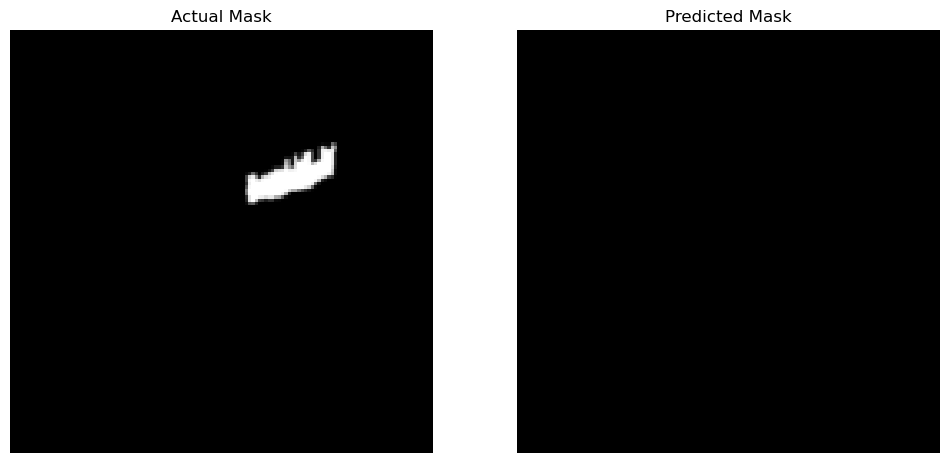

In [17]:
import matplotlib.pyplot as plt

# Function to display the predicted and actual masks
def display_masks(predicted, actual):
    # Convert tensors to numpy arrays and move to CPU
    predicted_np = predicted.detach().cpu().numpy().squeeze()  # Remove channel dimension
    actual_np = actual.detach().cpu().numpy().squeeze()  # Remove channel dimension

    # Set up the figure and axes
    plt.figure(figsize=(12, 6))
    
    # Display actual mask
    plt.subplot(1, 2, 1)
    plt.title("Actual Mask")
    plt.imshow(actual_np, cmap='gray')
    plt.axis('off')

    # Display predicted mask
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_np, cmap='gray')
    plt.axis('off')

    plt.show()

# Evaluation to display masks for a single batch
model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for img, mask in dataloader:
        img, mask = img.to('cuda' if torch.cuda.is_available() else 'cpu'), mask.to('cuda' if torch.cuda.is_available() else 'cpu')
        output = model(img)
        output = torch.sigmoid(output)  # Apply sigmoid to get probabilities
        predicted = (output > 0.5).float()  # Thresholding

        # Display masks for the first image in the batch
        display_masks(predicted[0], mask[0])  # Use the first image and its mask
        break  # Remove this line if you want to display masks for more images


In [1]:
#U-Net Full Model
import os
import numpy as np
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Define paths
IMAGE_PATH = r"C:\Users\chand\Downloads\OneDrive-2024-10-30\image"
MASK_PATH = r"C:\Users\chand\Downloads\OneDrive-2024-10-30\mask"

# Load images with naming conventions
def load_images_and_masks(image_path, mask_path, img_size=(256, 256)):
    authentic_images, forged_images, masks = [], [], []

    # Get lists of image and mask files
    image_files = sorted([f for f in os.listdir(image_path) if f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_path) if f.endswith('.tif')])

    for img_name in image_files:
        img_full_path = os.path.join(image_path, img_name)
        img = load_img(img_full_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize

        if 't.tif' in img_name:  # Check for forged images
            forged_images.append(img_array)
            
            # Find corresponding mask
            base_name = img_name.replace("t.tif", "")
            mask_file = next((f for f in mask_files if base_name in f), None)
            
            if mask_file:
                mask_full_path = os.path.join(mask_path, mask_file)
                mask_img = load_img(mask_full_path, target_size=img_size, color_mode="grayscale")
                mask_array = img_to_array(mask_img) / 255.0
                masks.append(mask_array)
            else:
                print(f"No mask found for forged image {img_name}")
        else:
            authentic_images.append(img_array)  # Authentic images have no mask

    return np.array(authentic_images), np.array(forged_images), np.array(masks)

# Load data
authentic_images, forged_images, masks = load_images_and_masks(IMAGE_PATH, MASK_PATH)

# Verify forged images and masks counts match
assert len(forged_images) == len(masks), "Forged images and masks count mismatch."

# Combine authentic and forged images, and set masks
data_images = np.concatenate([authentic_images, forged_images], axis=0)
data_masks = np.concatenate([np.zeros_like(masks), masks], axis=0)  # Masks for authentic images are zeros

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(data_images, data_masks, test_size=0.2, random_state=42)

# Define the U-Net model with reduced layers
def unet_model(input_shape=(256, 256, 3), num_filters=16, dropout=0.1):
    inputs = Input(input_shape)

    # Downsampling
    c1 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout)(p1)
    
    c2 = layers.Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout)(p2)
    
    # Bottleneck
    c3 = layers.Conv2D(num_filters * 4, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(num_filters * 4, (3, 3), activation='relu', padding='same')(c3)

    # Upsampling
    u1 = layers.Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(num_filters * 2, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Compile the model
model = unet_model()
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 8
epochs = 10
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

# Save the model
model.save('unet_image_forgery_detection.h5')

# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")


Epoch 1/10


C:\Users\chand\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 422ms/step - accuracy: 0.9347 - loss: 0.4127 - val_accuracy: 0.9480 - val_loss: 0.2832
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 422ms/step - accuracy: 0.9382 - loss: 0.2685 - val_accuracy: 0.9480 - val_loss: 0.2582
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 432ms/step - accuracy: 0.9326 - loss: 0.2803 - val_accuracy: 0.9480 - val_loss: 0.2343
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 437ms/step - accuracy: 0.9335 - loss: 0.2662 - val_accuracy: 0.9480 - val_loss: 0.2292
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 440ms/step - accuracy: 0.9347 - loss: 0.2589 - val_accuracy: 0.9480 - val_loss: 0.2195
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 445ms/step - accuracy: 0.9430 - loss: 0.2267 - val_accuracy: 0.9480 - val_loss: 0.2187
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 451ms/step - accuracy: 0.9439 - loss: 0.2224 - val_accuracy: 0.9480 - val_loss: 0.2199
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 444ms/step - accuracy: 0.9314 - loss: 0.2588 - val_accuracy: 0.9480 - val

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.9474 - loss: 0.2121
Validation Loss: 0.21066465973854065, Validation Accuracy: 0.9479648470878601


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step


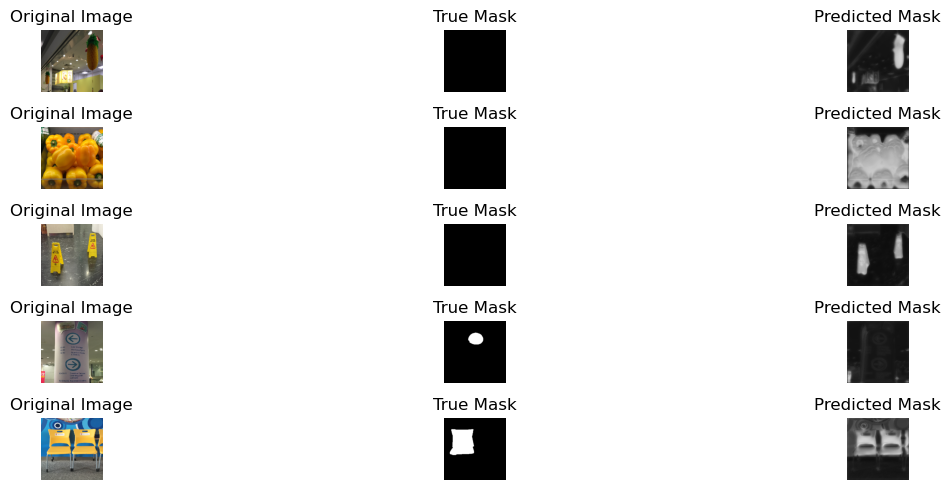

In [6]:
 import matplotlib.pyplot as plt

# Function to display the original image, true mask, and predicted mask
def display_predictions(x_val, y_val, model, num_images=5):
    # Generate predictions
    predictions = model.predict(x_val)

    # Set up the plot
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        # Original Image
        ax = plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(x_val[i])
        plt.title("Original Image")
        plt.axis("off")
        
        # True Mask
        ax = plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(y_val[i].squeeze(), cmap='gray')  # Squeeze to remove channels
        plt.title("True Mask")
        plt.axis("off")
        
        # Predicted Mask
        ax = plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()
display_predictions(x_val, y_val, model, num_images=5)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


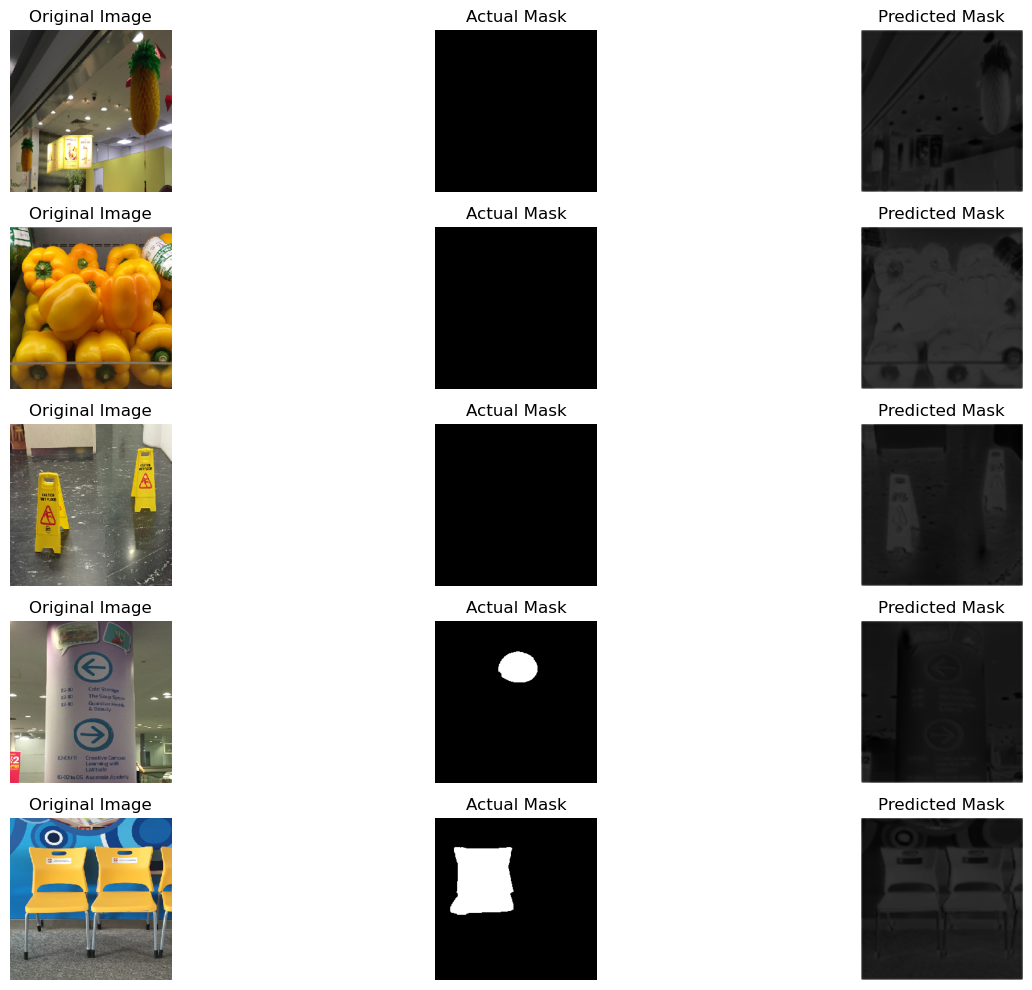

In [9]:
import matplotlib.pyplot as plt

# Make predictions on the validation set
predicted_masks = model.predict(x_val)

# Define a function to display actual and predicted masks
def display_masks(x, y_true, y_pred, num_samples=5):
    plt.figure(figsize=(15, 10))
    
    for i in range(num_samples):
        # Display original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(x[i])
        plt.title("Original Image")
        plt.axis("off")
        
        # Display actual mask
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.title("Actual Mask")
        plt.axis("off")
        
        # Display predicted mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Display masks
display_masks(x_val, y_val, predicted_masks)


In [10]:
from sklearn.metrics import accuracy_score

# Threshold the predicted masks to create binary masks
threshold = 0.5
predicted_binary_masks = (predicted_masks > threshold).astype(np.uint8)

# Flatten the masks to compare
y_val_flat = y_val.reshape(-1)
predicted_flat = predicted_binary_masks.reshape(-1)

# Calculate accuracy
accuracy = accuracy_score(y_val_flat, predicted_flat)
print(f"Accuracy of the predicted masks: {accuracy:.4f}")


Accuracy of the predicted masks: 0.9480


Epoch 1/10


C:\Users\chand\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1510']. Received: the structure of inputs=*
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 107s 5s/step - accuracy: 0.9251 - loss: 0.3861 - val_accuracy: 0.9480 - val_loss: 0.2717
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 110s 6s/step - accuracy: 0.9347 - loss: 0.2787 - val_accuracy: 0.9480 - val_loss: 0.2482
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.9286 - loss: 0.2737 - val_accuracy: 0.9480 - val_loss: 0.2240
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - accuracy: 0.9368 - loss: 0.2441 - val_accuracy: 0.9480 - val_loss: 0.2179
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.9383 - loss: 0.2394 - val_accuracy: 0.9480 - val_loss: 0.2107
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 113s 6s/step - accuracy: 0.9338 - loss: 0.2498 - val_accuracy: 0.9480 - val_loss: 0.2086
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 119s 6s/step - accuracy: 0.9412 - loss: 0.2317 - val_accuracy: 0.9480 - val_loss: 0.2133
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 119s 6s/step - accuracy: 0.9399 - loss: 0.2300 - val_accuracy: 0.9480 - val_loss: 0.

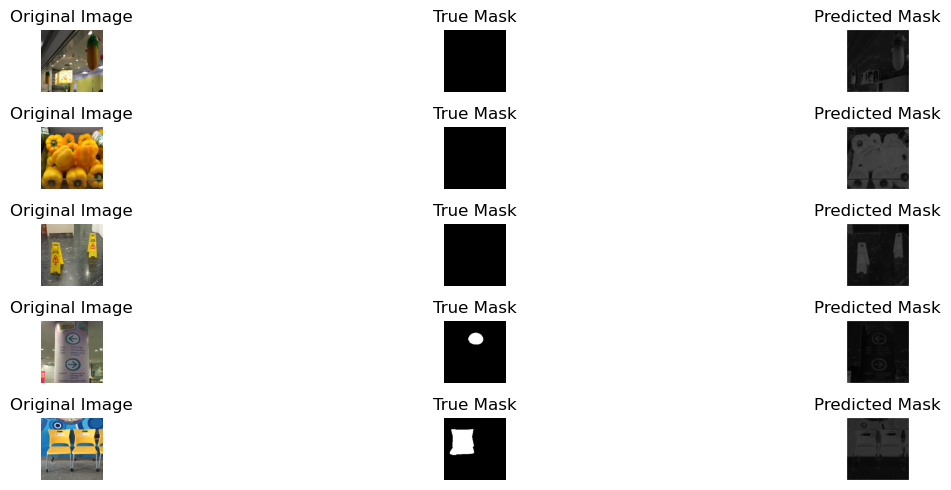

In [20]:
#FCN model
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Define paths
IMAGE_PATH = r"C:\Users\chand\Downloads\OneDrive-2024-10-30\image"
MASK_PATH = r"C:\Users\chand\Downloads\OneDrive-2024-10-30\mask"

# Load images and masks
def load_images_and_masks(image_path, mask_path, img_size=(256, 256)):
    authentic_images, forged_images, masks = [], [], []
    image_files = sorted([f for f in os.listdir(image_path) if f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_path) if f.endswith('.tif')])

    for img_name in image_files:
        img_full_path = os.path.join(image_path, img_name)
        img = load_img(img_full_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize

        if 't.tif' in img_name:
            forged_images.append(img_array)
            base_name = img_name.replace("t.tif", "")
            mask_file = next((f for f in mask_files if base_name in f), None)
            if mask_file:
                mask_full_path = os.path.join(mask_path, mask_file)
                mask_img = load_img(mask_full_path, target_size=img_size, color_mode="grayscale")
                mask_array = img_to_array(mask_img) / 255.0
                masks.append(mask_array)
            else:
                print(f"No mask found for forged image {img_name}")
        else:
            authentic_images.append(img_array)

    return np.array(authentic_images), np.array(forged_images), np.array(masks)

# Load data
authentic_images, forged_images, masks = load_images_and_masks(IMAGE_PATH, MASK_PATH)

# Ensure counts match
assert len(forged_images) == len(masks), "Forged images and masks count mismatch."

# Prepare datasets
data_images = np.concatenate([authentic_images, forged_images], axis=0)
data_masks = np.concatenate([np.zeros_like(masks), masks], axis=0)
x_train, x_val, y_train, y_val = train_test_split(data_images, data_masks, test_size=0.2, random_state=42)

# Define FCN model
def fcn_model(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u1 = layers.concatenate([u1, c4])  # Concatenate with corresponding encoder layer
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)

    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u2 = layers.concatenate([u2, c3])  # Concatenate with corresponding encoder layer
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)

    u3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u3 = layers.concatenate([u3, c2])  # Concatenate with corresponding encoder layer
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)

    u4 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u4 = layers.concatenate([u4, c1])  # Concatenate with corresponding encoder layer
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u4)

    # Final layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model.save('image_forgery_FCN.h5')

# Compile and train the FCN model
fcn_model_instance = fcn_model()
fcn_model_instance.compile(loss='binary_crossentropy', metrics=['accuracy'])
history_fcn = fcn_model_instance.fit(x_train, y_train, batch_size=8, epochs=10, validation_data=(x_val, y_val))

# Evaluate the model
loss, accuracy = fcn_model_instance.evaluate(x_val, y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

# Function to display predictions
def display_predictions(x_val, y_val, model, num_images=5):
    predictions = model.predict(x_val)
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        ax = plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(x_val[i])
        plt.title("Original Image")
        plt.axis("off")
        
        ax = plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(y_val[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis("off")
        
        ax = plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
display_predictions(x_val, y_val, fcn_model_instance, num_images=5)


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Mean IoU over validation set: 0.5250000001210317


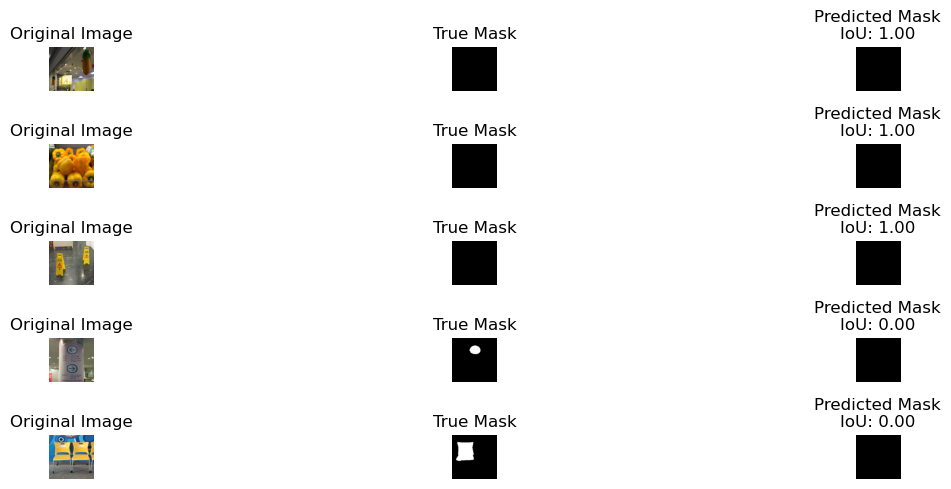

In [21]:
# Function to calculate Intersection over Union (IoU)
def calculate_iou(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Evaluate the model and calculate IoU for validation set
predictions = fcn_model_instance.predict(x_val)
predictions_binary = (predictions > 0.5).astype(np.uint8)  # Convert predictions to binary

# Calculate IoU for each prediction
iou_scores = [calculate_iou(y_val[i].squeeze(), predictions_binary[i].squeeze()) for i in range(len(y_val))]
mean_iou = np.mean(iou_scores)

print(f"Mean IoU over validation set: {mean_iou}")

# Function to display predictions with IoU scores
def display_predictions_with_iou(x_val, y_val, predictions, iou_scores, num_images=5):
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        ax = plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(x_val[i])
        plt.title("Original Image")
        plt.axis("off")
        
        ax = plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(y_val[i].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis("off")
        
        ax = plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title(f"Predicted Mask\nIoU: {iou_scores[i]:.2f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Visualize predictions with IoU scores
display_predictions_with_iou(x_val, y_val, predictions_binary, iou_scores, num_images=5)


In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

# Define paths
IMAGE_PATH = r"C:\Users\chand\Downloads\OneDrive-2024-10-30\image"
MASK_PATH = r"C:\Users\chand\Downloads\OneDrive-2024-10-30\mask"

# Load images and masks
def load_images_and_masks(image_path, mask_path, img_size=(256, 256)):
    authentic_images, forged_images, masks = [], [], []

    image_files = sorted([f for f in os.listdir(image_path) if f.endswith('.tif')])
    mask_files = sorted([f for f in os.listdir(mask_path) if f.endswith('.tif')])

    for img_name in image_files:
        img_full_path = os.path.join(image_path, img_name)
        img = load_img(img_full_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0  # Normalize

        if 't.tif' in img_name:
            forged_images.append(img_array)
            base_name = img_name.replace("t.tif", "")
            mask_file = next((f for f in mask_files if base_name in f), None)
            
            if mask_file:
                mask_full_path = os.path.join(mask_path, mask_file)
                mask_img = load_img(mask_full_path, target_size=img_size, color_mode="grayscale")
                mask_array = img_to_array(mask_img) / 255.0
                masks.append(mask_array)
            else:
                print(f"No mask found for forged image {img_name}")
        else:
            authentic_images.append(img_array)

    return np.array(authentic_images), np.array(forged_images), np.array(masks)

# Load data
authentic_images, forged_images, masks = load_images_and_masks(IMAGE_PATH, MASK_PATH)

# Verify forged images and masks counts match
assert len(forged_images) == len(masks), "Forged images and masks count mismatch."

# Create binary labels
num_authentic = len(authentic_images)
num_forged = len(forged_images)

# Create binary labels: 0 for authentic, 1 for forged
y_authentic = np.zeros(num_authentic)
y_forged = np.ones(num_forged)

# Combine images and labels
data_images = np.concatenate([authentic_images, forged_images], axis=0)
data_labels = np.concatenate([y_authentic, y_forged], axis=0)

# Split the dataset
x_train, x_val, y_train, y_val = train_test_split(data_images, data_labels, test_size=0.2, random_state=42)

# DenseNet model definition
def densenet_model(input_shape=(256, 256, 3)):
    base_model = tf.keras.applications.DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Adding dropout
    x = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=base_model.input, outputs=x)
    return model

# Compile the model
model = densenet_model()
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 8
epochs = 10
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(x_val, y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

# Save the model
model.save('densenet_image_forgery_detection.h5')


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 181s 5s/step - accuracy: 0.5377 - loss: 1.3114 - val_accuracy: 0.5250 - val_loss: 4316.8691
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.4105 - loss: 1.0565 - val_accuracy: 0.5000 - val_loss: 98.9494
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.4511 - loss: 0.9086 - val_accuracy: 0.4750 - val_loss: 1558.8496
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.4470 - loss: 0.8680 - val_accuracy: 0.5250 - val_loss: 77165.6641
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.5874 - loss: 0.6929 - val_accuracy: 0.5250 - val_loss: 333.9809
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.4902 - loss: 0.7319 - val_accuracy: 0.5250 - val_loss: 0.7032
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.4363 - loss: 0.7572 - val_accuracy: 0.5250 - val_loss: 4.4101
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.4435 - loss: 0.7323 - val_accuracy: 0.52

Validation Loss: 7.991326808929443, Validation Accuracy: 0.5


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step


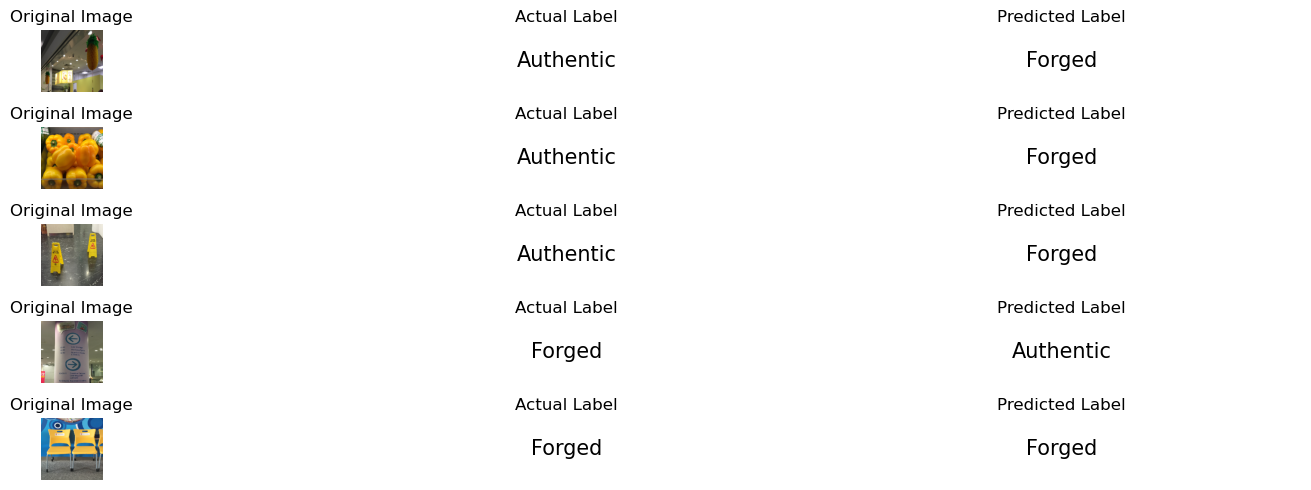

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the existing DenseNet model
model = tf.keras.models.load_model('densenet_image_forgery_detection.h5')

def display_predicted_vs_actual(x_val, y_val, model, num_images=5):
    # Generate predictions
    predictions = model.predict(x_val)

    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        # Display original image
        ax = plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(x_val[i])
        plt.title("Original Image")
        plt.axis("off")
        
        # Display actual label
        actual_label = 'Forged' if y_val[i] == 1 else 'Authentic'
        ax = plt.subplot(num_images, 3, i * 3 + 2)
        plt.text(0.5, 0.5, actual_label, fontsize=15, ha='center', va='center')
        plt.title("Actual Label")
        plt.axis("off")
        
        # Display predicted label
        predicted_label = 'Forged' if predictions[i] > 0.5 else 'Authentic'
        ax = plt.subplot(num_images, 3, i * 3 + 3)
        plt.text(0.5, 0.5, predicted_label, fontsize=15, ha='center', va='center')
        plt.title("Predicted Label")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Assuming you have x_val and y_val prepared from your previous code
display_predicted_vs_actual(x_val, y_val, model, num_images=5)
